In [1]:
from qutip import *
import numpy as np
import random
import matplotlib.pyplot as plt


 ## Utilities

 Builds a state of the form $(k0 |0> + k1 |1>) \otimes |0>^{num\_zeros}$

In [2]:
def build_initial(k0, k1, num_zeros):
    # Normalize the state
    kmag = np.sqrt(k0.conjugate() * k0+ k1.conjugate() * k1)
    nk0 = k0/kmag
    nk1 = k1/kmag
    # Construct the state as k0 [1, 0] + k1 [0, 1]
    output = nk0 * basis(2, 0) + nk1 * basis(2, 1)

    # Add in the extra zeroes at the end
    for cur in range(0, num_zeros):
        output = tensor(output, basis(2, 0))
    return output.unit()

 Applies a *classical* 1 bit bitflip error to density matrix $rho$
 with probability $p$.

In [3]:
def apply_bitflip(rho, p, bit):
    flip_matrix = []
    num_bits = int(np.log(max(rho.shape)) /np.log(2))
    for idx in range(0, num_bits):
        if idx == bit:
            flip_matrix.append(sigmax())
        else:
            flip_matrix.append(identity(2))
    flip_op = tensor(flip_matrix)
    return (1 - p) * rho + p * flip_op * rho * flip_op.dag()

 Applies a *classical* 1 bit signflip error to density matrix $rho$
 with probability $p$.

In [4]:
def apply_signflip(rho, p, bit):
    flip_matrix = []
    num_bits = int(np.log(max(rho.shape)) /np.log(2))
    for idx in range(0, num_bits):
        if idx == bit:
            flip_matrix.append(sigmaz())
        else:
            flip_matrix.append(identity(2))
    flip_op = tensor(flip_matrix)
    return (1 - p) * rho + p * flip_op * rho * flip_op.dag()

 Operator to apply a *quantum* 1 bit bitflip error to a single qbit.

In [5]:
def qbitflip(epsilon):
    return Qobj(np.array([
        [np.sqrt(1 - epsilon), np.sqrt(epsilon)], 
        [-np.sqrt(epsilon), np.sqrt(1 - epsilon)], 
    ]))

 Operator to apply a *quantum* 1 bit phaseflip error to a single qbit.

In [6]:
def qphaseflip(epsilon):
    bit_mat = qbitflip(epsilon)
    ret = snot() * bit_mat * snot() 
    return ret

 Applies an operator equivalent to $\sum_{i\in states} |i>$ to density
 matrix $rho$, while still preserving the dimension of $rho$.

In [7]:
def project_states(rho, states):
    ret = rho.copy()
    for xidx in range(0, rho.shape[0]):
        for yidx in range(0, rho.shape[1]):
            if not xidx in states and not yidx in states:
                ret.data[xidx, yidx] = 0.0 
    ret = ret.unit()
    return ret 


 Generalized error gate. $ptheta$ and $pphi$ become polar angle coordinates
 both normalized to [0, 1], with the matrix evaluating to a projection from the
 resultant coordinate transform to a sum of $I, X, Z$.

In [8]:
def qerror(ptheta, pphi):
    return qphaseflip(ptheta) * qbitflip(pphi)

/usr/lib/python3/dist-packages/qutip/qip/circuit.py:162: UserWarning: Unknown gate E_f
  warnings.warn("Unknown gate %s" % name)


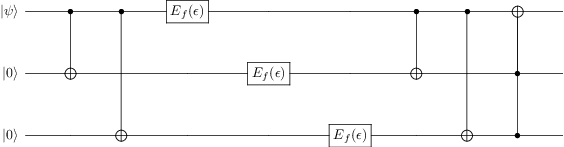

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.85381497  0.28460499  0.28460499  0.09486833  0.03162278  0.09486833
   0.09486833  0.28460499]
 [-0.28460499  0.85381497 -0.09486833  0.28460499  0.09486833 -0.03162278
   0.28460499 -0.09486833]
 [-0.28460499 -0.09486833  0.85381497  0.28460499  0.09486833  0.28460499
  -0.03162278 -0.09486833]
 [-0.28460499 -0.09486833 -0.09486833 -0.03162278  0.09486833  0.28460499
   0.28460499  0.85381497]
 [-0.03162278  0.09486833  0.09486833 -0.28460499  0.85381497 -0.28460499
  -0.28460499  0.09486833]
 [ 0.09486833  0.03162278 -0.28460499 -0.09486833  0.28460499  0.85381497
  -0.09486833 -0.28460499]
 [ 0.09486833 -0.28460499  0.03162278 -0.09486833  0.28460499 -0.09486833
   0.85381497 -0.28460499]
 [ 0.09486833 -0.28460499 -0.28460499  0.85381497  0.28460499 -0.09486833
  -0.09486833  0.03162278]]

In [9]:
three_bit_ts = QubitCircuit(3, reverse_states=False)
three_bit_ts.add_state('\psi', targets=[0], state_type='input')
three_bit_ts.add_state('0', targets=[1, 2], state_type='input')
three_bit_ts.add_gate('CNOT', controls=[0], targets = [1])
three_bit_ts.add_gate('CNOT', controls=[0], targets = [2])
three_bit_ts.user_gates = {'E_f' :  qbitflip, 'Flip' : sigmax, 'E_p' : qphaseflip}
three_bit_ts.add_gate('E_f', targets=[0], arg_value=0.1, arg_label="\epsilon")
three_bit_ts.add_gate('E_f', targets=[1], arg_value=0.1, arg_label="\epsilon")
three_bit_ts.add_gate('E_f', targets=[2], arg_value=0.1, arg_label="\epsilon")
three_bit_ts.add_gate('CNOT', controls=[0], targets = [1])
three_bit_ts.add_gate('CNOT', controls=[0], targets = [2])
three_bit_ts.add_gate('TOFFOLI', controls=[1, 2], targets=[0])
display(three_bit_ts.png)
display(gate_sequence_product(three_bit_ts.propagators()).tidyup())


In [10]:
test_inp = build_initial(1, 0, 2)
display(test_inp.ptrace([0]))
display((qbitflip(0.1) * basis(2, 0)).ptrace([0]))
display((gate_sequence_product(three_bit_ts.propagators()) * test_inp).ptrace([0]).unit().tidyup())
display((gate_sequence_product(three_bit_ts.propagators()) * test_inp).ptrace([0]).unit().tidyup().purity())


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.9 -0.3]
 [-0.3  0.1]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.972 -0.108]
 [-0.108  0.028]]

0.9688960000000004

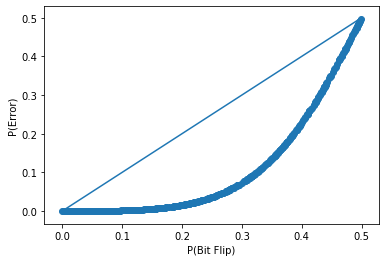

In [11]:
def perform_test():
    epsilon = random.random() * 0.5
    initial_state = build_initial(0, 1, 2).unit()
    initial_error = (qbitflip(epsilon) * initial_state.extract_states([0, 4], normalize = True)).unit()
    initial_error_val = 1 - abs((initial_state.extract_states([0, 4], normalize=True).dag() * initial_error)[0,0])**2
    three_bit_ts.user_gates['E_f'] = lambda x: qbitflip(epsilon)
    corrected_error = (gate_sequence_product(three_bit_ts.propagators()) * initial_state).extract_states([0, 4], normalize=True)
    corrected_error_val = abs( (initial_state.extract_states([0, 4], normalize = True).dag() * corrected_error)[0, 0])**2
    return (epsilon, 1 - corrected_error_val)

xdata = []
ydata = []
for test in range(0, 500):
    cur = perform_test()
    xdata.append(cur[0])
    ydata.append(cur[1])
fit_function = xdata.copy()
fit_function.sort()
plt.xlabel('P(Bit Flip)')
plt.ylabel('P(Error)')
plt.plot(fit_function, fit_function)
plt.scatter(xdata, ydata)
plt.show()



/usr/lib/python3/dist-packages/qutip/qip/circuit.py:162: UserWarning: Unknown gate Error
  warnings.warn("Unknown gate %s" % name)


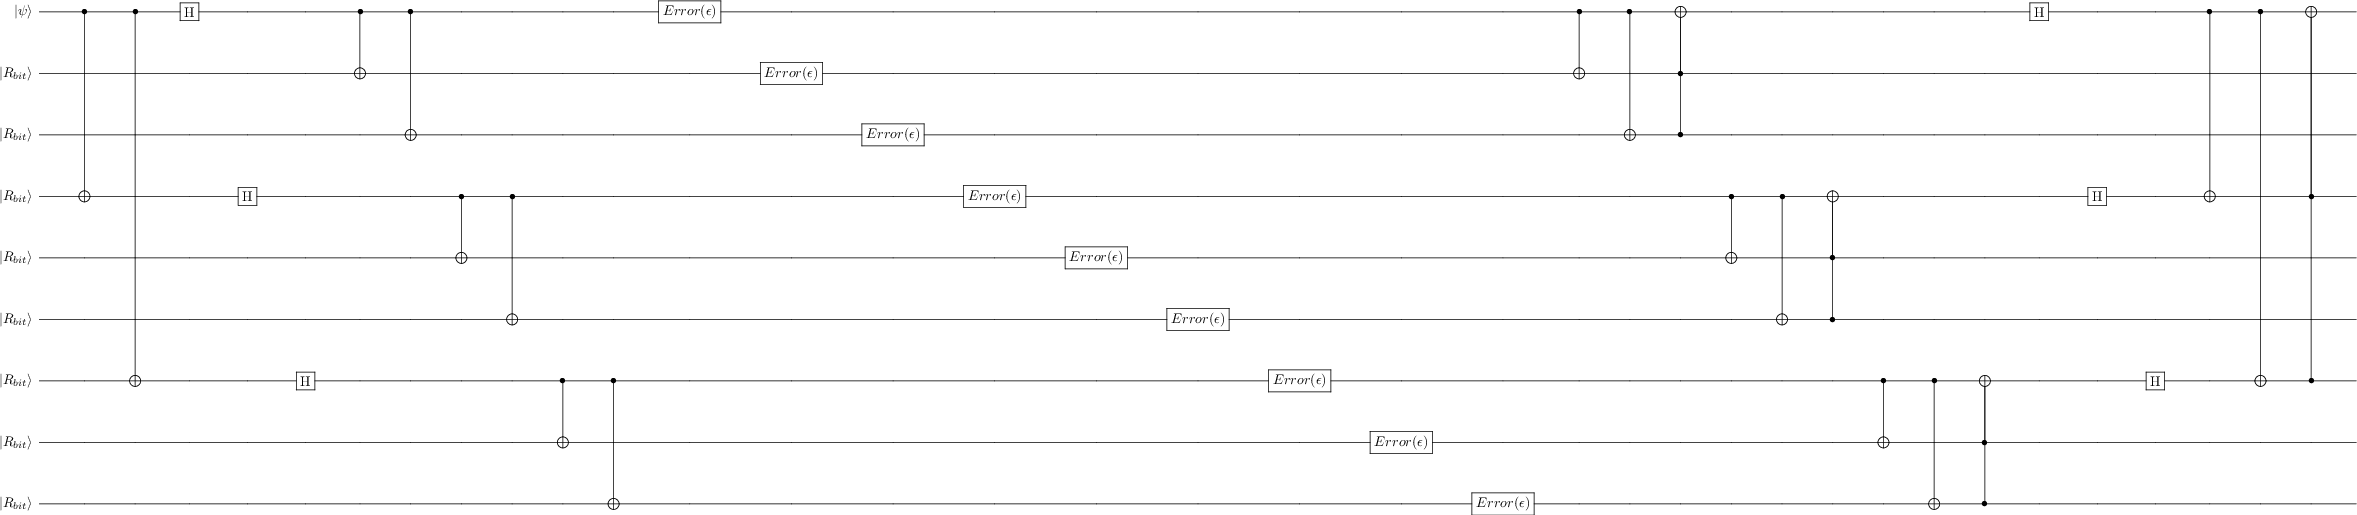

In [12]:
nine_bit_ts = QubitCircuit(9, reverse_states=False)
nine_bit_ts.user_gates = {'E_f' :  qbitflip, 'Flip' : sigmax, 'E_p' : qphaseflip, 'Error' : lambda : qerror(0.4, 0.4)}
nine_bit_ts.add_state('\psi', targets=[0], state_type='input')
nine_bit_ts.add_state('R_{bit}', targets=[1, 2, 3, 4, 5, 6, 7, 8], state_type='input')
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [3])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [6])
nine_bit_ts.add_gate('SNOT', targets=[0])
nine_bit_ts.add_gate('SNOT', targets=[3])
nine_bit_ts.add_gate('SNOT', targets=[6])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [1])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [2])
nine_bit_ts.add_gate('CNOT', controls=[3], targets = [4])
nine_bit_ts.add_gate('CNOT', controls=[3], targets = [5])
nine_bit_ts.add_gate('CNOT', controls=[6], targets = [7])
nine_bit_ts.add_gate('CNOT', controls=[6], targets = [8])
for idx in range(0, 9):
    nine_bit_ts.add_gate('Error', targets=[idx],  arg_label="\epsilon")
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [1])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [2])
nine_bit_ts.add_gate('TOFFOLI', controls=[1, 2], targets=[0])
nine_bit_ts.add_gate('CNOT', controls=[3], targets = [4])
nine_bit_ts.add_gate('CNOT', controls=[3], targets = [5])
nine_bit_ts.add_gate('TOFFOLI', controls=[4, 5], targets=[3])
nine_bit_ts.add_gate('CNOT', controls=[6], targets = [7])
nine_bit_ts.add_gate('CNOT', controls=[6], targets = [8])
nine_bit_ts.add_gate('TOFFOLI', controls=[7, 8], targets=[6])
nine_bit_ts.add_gate('SNOT', targets=[0])
nine_bit_ts.add_gate('SNOT', targets=[3])
nine_bit_ts.add_gate('SNOT', targets=[6])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [3])
nine_bit_ts.add_gate('CNOT', controls=[0], targets = [6])
nine_bit_ts.add_gate('TOFFOLI', controls=[3, 6], targets=[0])

display(nine_bit_ts.png)


In [13]:
inp = build_initial(np.sqrt(0.2), np.sqrt(0.8) * 1j, 8).unit()
display(inp.extract_states([0, 2**8], normalize=True))
display(nine_bit_ts.user_gates['Error']())
display( (nine_bit_ts.user_gates['Error']() *  inp.extract_states([0, 2**8], normalize=True) ).unit())
display((gate_sequence_product(nine_bit_ts.propagators()) * inp).extract_states([0, 2**8], normalize=True))

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.4472136+0.j        ]
 [0.       +0.89442719j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.4472136+0.j        ]
 [0.       +0.89442719j]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.4472136+0.j        ]
 [0.       +0.89442719j]]

In [14]:

def perform_ninebit_test():
    epsilon1 = random.random() * 1.0
    epsilon2 = random.random() * 1.0
    err_gate = qerror(epsilon1, epsilon2)
    initial_state = build_initial(0, 1, 8).unit()
    initial_substate = initial_state.extract_states([0, 256], normalize=True)
    initial_error = (err_gate * initial_substate).unit()
    initial_error_val = 1 - abs((initial_substate.dag() * initial_error)[0,0])**2
    nine_bit_ts.user_gates['Error'] = lambda: err_gate
    corrected_error = (gate_sequence_product(nine_bit_ts.propagators()) * initial_state).extract_states([0, 256], normalize=True)
    corrected_error_val = 1 - abs( (initial_substate.dag() * corrected_error)[0, 0])**2
    return ((epsilon1, epsilon2, initial_error_val),  corrected_error_val)

xdata = []
xdata2 = []
xdata3 = []
xdata4 = []
xdata5 = []
xdata6 = []
ydata = []
for test in range(0, 400):
    cur = perform_ninebit_test()
    xdata.append(cur[0][0])
    xdata2.append(cur[0][1])
    xdata3.append(cur[0][1] + cur[0][0])
    xdata4.append(cur[0][1]**2 + cur[0][0]**2)
    xdata5.append(np.sqrt(cur[0][1]**2 + cur[0][0]**2))
    xdata6.append(cur[0][2])
    ydata.append(cur[1])

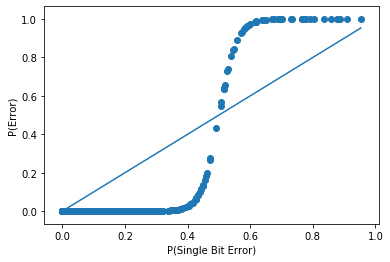

In [15]:

fit_function = xdata6.copy()
fit_function.sort()
plt.xlabel('P(Single Bit Error)')
plt.ylabel('P(Error)')
plt.plot(fit_function, [ y for y in fit_function])
plt.scatter([k for k in xdata6], [y for y in ydata])
plt.show()
